## Kod narzedzia do rysowania


In [1]:
import functools
import random
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes

    def set_axis(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(scenes)
        self.draw()

    def prev(self, event):
        self.i = (self.i - 1) % len(scenes)
        self.draw()
        
    def draw(self):
        self.ax.clear()
        for collection in self.scenes[self.i].points:
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), c=collection.color, marker=collection.marker)
        for collection in self.scenes[self.i].lines:
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale()
        plt.draw()

In [2]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points = [], color = None, marker = None):
        self.points = np.array(points)
        self.color = color
        self.marker = marker

class LinesCollection:
    def __init__(self, lines = [], color = None):
        self.color = color
        self.lines = np.array(lines)
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        if self.color:
            return mcoll.LineCollection(self.lines, colors=mcolors.to_rgba(self.color))
        else:
            return mcoll.LineCollection(self.lines)
            


class Plot:
    def __init__(self, scenes = [], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self, callback):
        plt.subplots_adjust(bottom=0.2)
        axprev = plt.axes([0.6, 0.05, 0.15, 0.075])
        axnext = plt.axes([0.76, 0.05, 0.15, 0.075])
        bnext = Button(axnext, 'Następny')
        bnext.on_clicked(callback.next)
        bprev = Button(axprev, 'Poprzedni')
        bprev.on_clicked(callback.prev)
        return [bprev, bnext]

    def draw(self):
        plt.close()
        callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons(callback)
        callback.set_axis(plt.axes())
        plt.show()
        callback.draw()
        
    def toJSON(self):
        return js.dumps([{"points": [pointCol.points.tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])
        

## Generowanie zbiorow


### Generuje zbior A


<IPython.core.display.Javascript object>


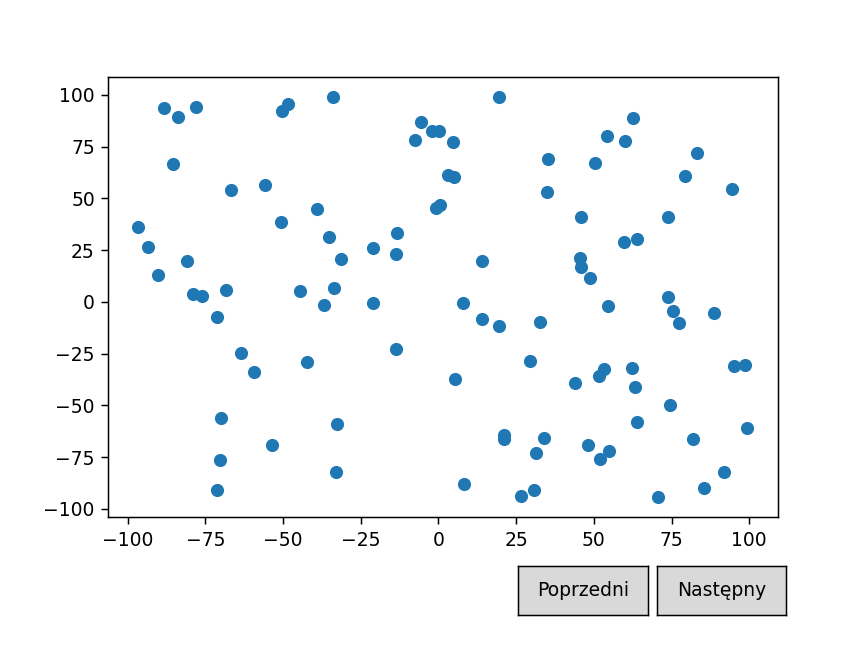

In [3]:
%matplotlib notebook
def generate_a(n = 100,r = 100):
    a_points = [(np.random.uniform(-r,r),np.random.uniform(-r,r)) for _ in range(n)]
    return a_points

plot = Plot([Scene([PointsCollection(generate_a())])])
plot.draw()


### Generuje zbior B


<IPython.core.display.Javascript object>


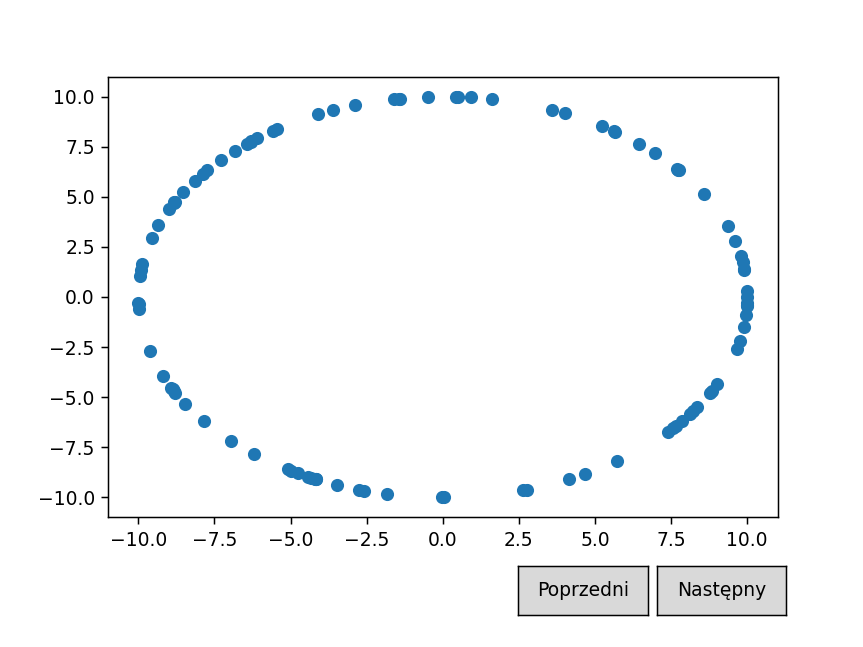

In [4]:
import math 
def generate_b(n = 100, s = (0,0), r = 10):
    b_points = []
    for _ in range(n):
        angle = np.random.uniform(0,2*math.pi)
        b_points.append((s[0]+r*math.sin(angle),s[1]+r*math.cos(angle)))
    return b_points
plot = Plot([Scene([PointsCollection(generate_b())])])
plot.draw()  


### Generuje zbior C

<IPython.core.display.Javascript object>


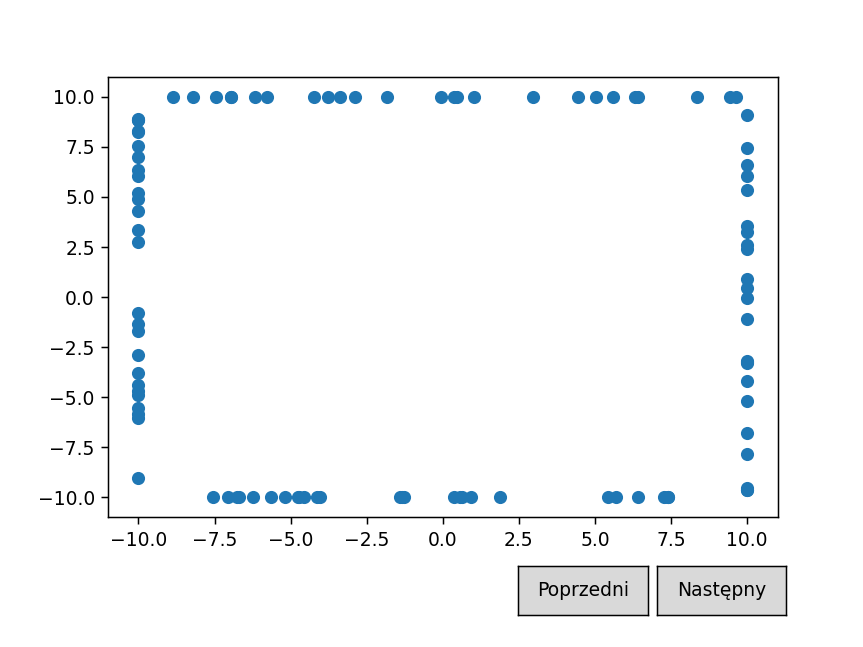

In [5]:

def generate_c(n = 100, UR = (10,10), LL = (-10,-10)):
    c_points = []
    a = UR[0] - LL[0]
    b = UR[1] - LL[1]
    r = 2*a + 2*b
    for _ in range(n):
        p = np.random.uniform(0,r)
        if p < a:
            c_points.append((LL[0]+p,UR[1]))
        elif p < a+b:
            c_points.append((UR[0],LL[1] + (p-a)))
        elif p < 2*a+b:
            c_points.append((LL[0] + p-(a+b),LL[1]))
        else:
            c_points.append((LL[0],LL[1] + p-(a+a+b)))
    return c_points    
        
plot = Plot([Scene([PointsCollection(generate_c())])])
plot.draw()  

### Generuje zbior D


<IPython.core.display.Javascript object>


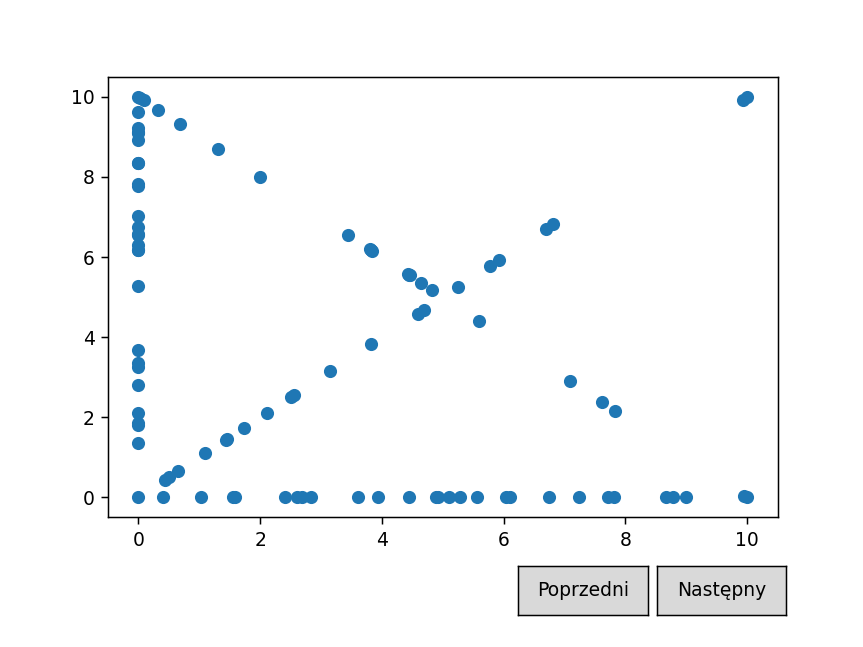

In [6]:


def generate_d(UR = (10,10), LL = (0,0), side_amount = 25, diag_amount = 20):
    
    length = UR[0] - LL[0]
    d_points = [UR,LL,(LL[0],UR[1]),(UR[0],LL[1])]
    
    for _ in range(side_amount):
        y = np.random.uniform(0,length)
        d_points.append((LL[0],LL[1]+y))

    for _ in range(side_amount):
        x = np.random.uniform(0,length)
        d_points.append((LL[0] + x,LL[1]))

    for _ in range(diag_amount):
        x = y = np.random.uniform(LL[0],LL[0]+ length)
        d_points.append((x,y))

    for _ in range(diag_amount):
        x = np.random.uniform(LL[0],LL[0]+length)
        y = length - x
        d_points.append((x,y))
    return d_points

plot = Plot([Scene([PointsCollection(generate_d())])])
plot.draw()  


## Algorytm Jarvisa


In [7]:
def det3x3(a,b,c):
    #Reguła Sarrusa
    # |ax ay 1|
    # |bx by 1|
    # |cx cy 1|
    return a[0] * b[1] + b[0] * c[1] + a[1] * c[0] - (c[0]*b[1] + a[1] * b[0] + c[1] * a[0])


def findMin(a,data,e):
    min = data[0]  
    for p in data[1:]:
        det = det3x3(a,min,p)
        if det > -e and det < e:
            length1 = math.sqrt((min[0] - a[0])**2 + (min[1] - a[1])**2)
            length2 = math.sqrt((p[0] - a[0])**2 + (p[1] - a[1])**2)
            if length1 < length2:
                min = p
            continue
        if det < -e:
            min = p
    return min


        
        

In [8]:
def jarvis_algorithm(data,e = 10**-12,save = False):
    lines = []
    scenes = []
    
    p0 = min(data, key = lambda x : (x[1],x[0]))
    hull = [p0]
    
    scenes.append(Scene([PointsCollection(data, color = "green"),PointsCollection(hull,color ="blue")]))
    
    p = findMin(p0,data,e)
    
    while p != p0:
        
        hull.append(p)
        lines.append([hull[-2],p])
        
        p = findMin(p,data,e)
        scenes.append(Scene([PointsCollection(data, color = "green"),PointsCollection(hull,color ="blue")],[LinesCollection(lines,color = "blue")]))
        
    lines.append([hull[0],hull[-1]])
    scenes.append(Scene([PointsCollection(data, color = "green"),PointsCollection(hull,color ="blue")],[LinesCollection(lines,color = "blue")]))
    
    if save:
        with open('jarvis.txt', 'w+') as f:
            for p in hull:
                f.write(str(p))
       
    return hull,scenes







## Algorytm Grahama


In [9]:
def compare(p0,a,b,e):
    if p0 == a:
        return -1 
    if p0 == b:
        return 1
    det = det3x3(p0,a,b)
    if det > e:
        return -1
    if det < -e:
        return 1
    if det < e and det > -e:
        return 0
    

def del_same_angle(data,p,e):
    i = 1
    while i < len(data) - 1:
        
        det = det3x3(p,data[i],data[i+1])
        if  det < e and det > -e:
            length1 = math.sqrt((data[i][0] - p[0])**2 + (data[i][1] - p[1])**2)
            length2 = math.sqrt((data[i+1][0] - p[0])**2 + (data[i+1][1] - p[1])**2)
            if length1 > length2:
                data.pop(i + 1)
                
                i = i - 1
                
            else:
                data.pop(i)
                i = i - 1
        i +=1
    
    return data


In [11]:
import copy
from functools import cmp_to_key
def graham_scan(data,e= 10**-12,save = False):
    scenes = []
    lines = []
    lines_curr = []
    
    
    data_c = copy.deepcopy(data)
    
    p0 = min(data_c, key = lambda x : (x[1],x[0]))
    scenes.append(Scene([PointsCollection(data, color = "green"),PointsCollection([p0],color ="blue")]))
    data_c = sorted(data_c,key = cmp_to_key(lambda a,b : compare(p0,a,b,e)))
    
    

    data_c = del_same_angle(data_c,p0,e)
    lines.append([data_c[0],data_c[1]])
    
    s = [data_c[0],data_c[1],data_c[2]]
    i = 3
   
    
    while i < len(data_c):
        line_curr = [(s[-2],s[-1])]
        scenes.append(Scene([PointsCollection(data, color = "green"),PointsCollection(s,color ="blue")],[LinesCollection(lines,color = "blue"),LinesCollection(line_curr,color = "green")]))
        if det3x3(s[-2],s[-1],data_c[i]) > e:
            lines.append([s[-2],s[-1]])
            s.append(data_c[i])
            i+=1
        else:
            lines.pop()
            s.pop()
        
    lines.append([s[-2],s[-1]])
    lines.append([s[-1],p0])
    
    scenes.append(Scene([PointsCollection(data, color = "green"),PointsCollection(s,color ="blue")],[LinesCollection(lines,color = "blue")]))
    if save:
        with open('graham.txt', 'w+') as f:
            for p in s:
                f.write(str(p))
    
    
    
    return s,scenes
        
    

    
    


    
    
    
    

## Algorytm Jarvisa na zbiorach


### Zbior A


<IPython.core.display.Javascript object>


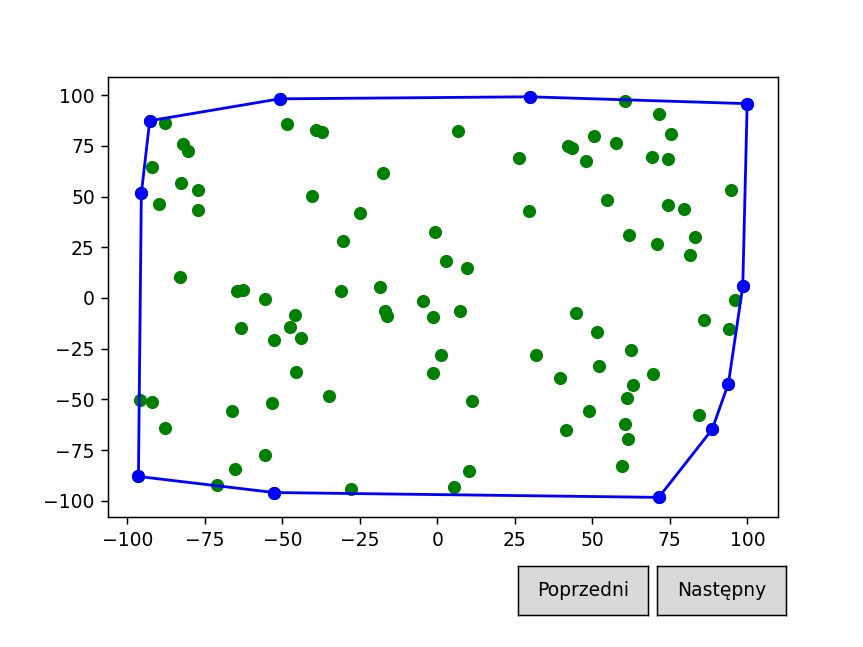

In [14]:
hull,scenes = jarvis_algorithm(generate_a())
plot = Plot(scenes)
plot.draw()

### Zbior B


<IPython.core.display.Javascript object>


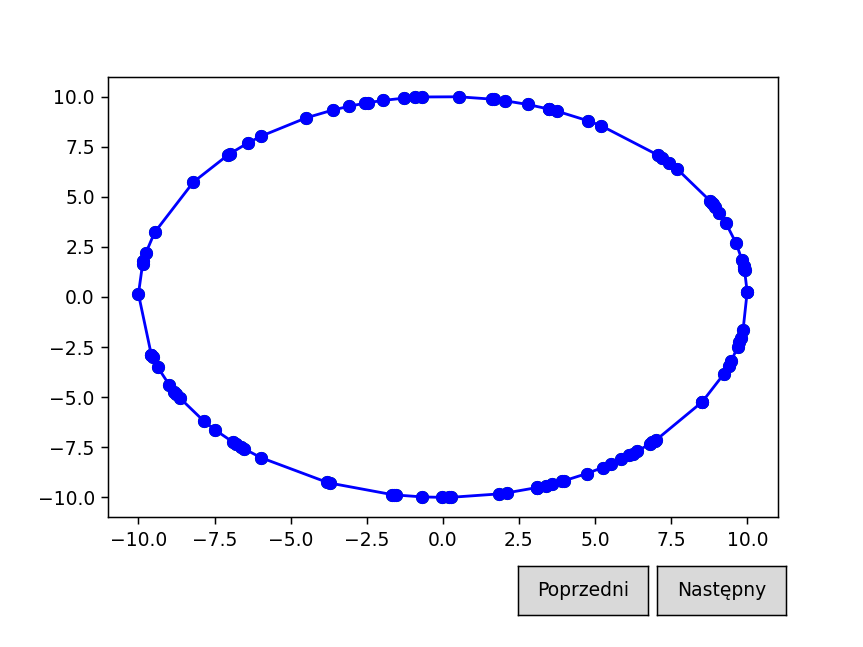

In [15]:
hull,scenes = jarvis_algorithm(generate_b())
plot = Plot(scenes)
plot.draw()

### Zbior C

<IPython.core.display.Javascript object>


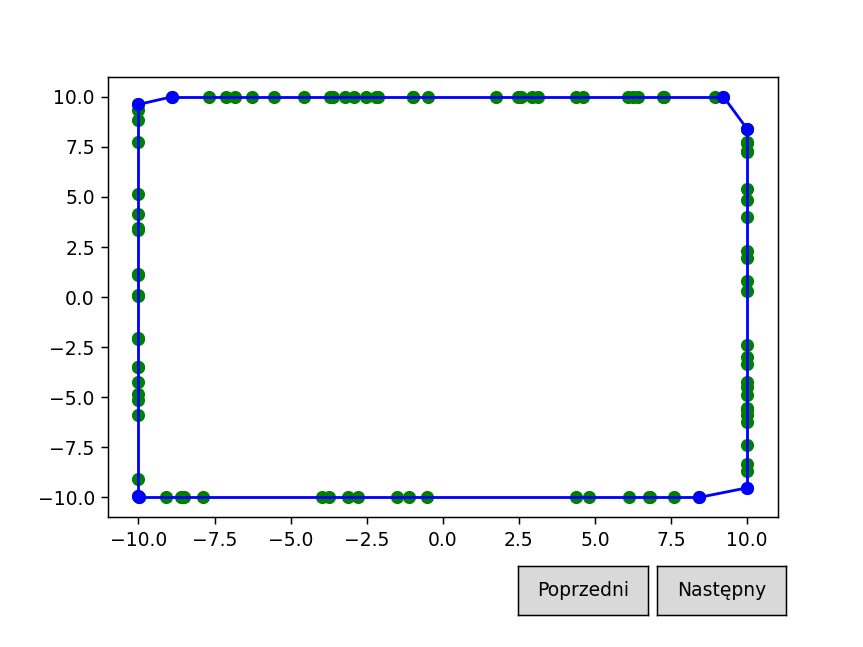

In [17]:
hull,scenes = jarvis_algorithm(generate_c())
plot = Plot(scenes)
plot.draw()

### Zbiór D


<IPython.core.display.Javascript object>


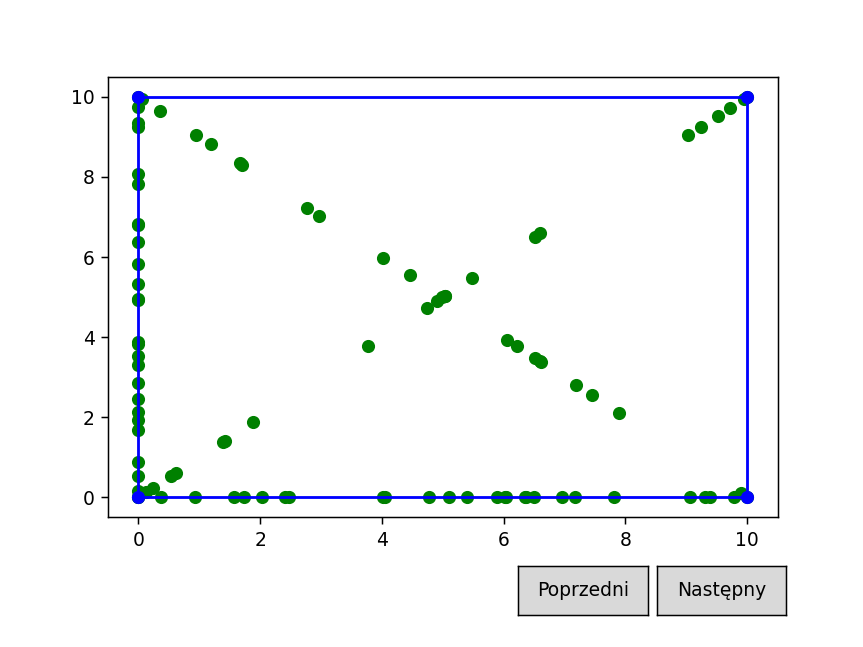

In [18]:
hull,scenes = jarvis_algorithm(generate_d())
plot = Plot(scenes)
plot.draw()

## Algorytm Grahama na zbiorach

### Zbiór A


<IPython.core.display.Javascript object>


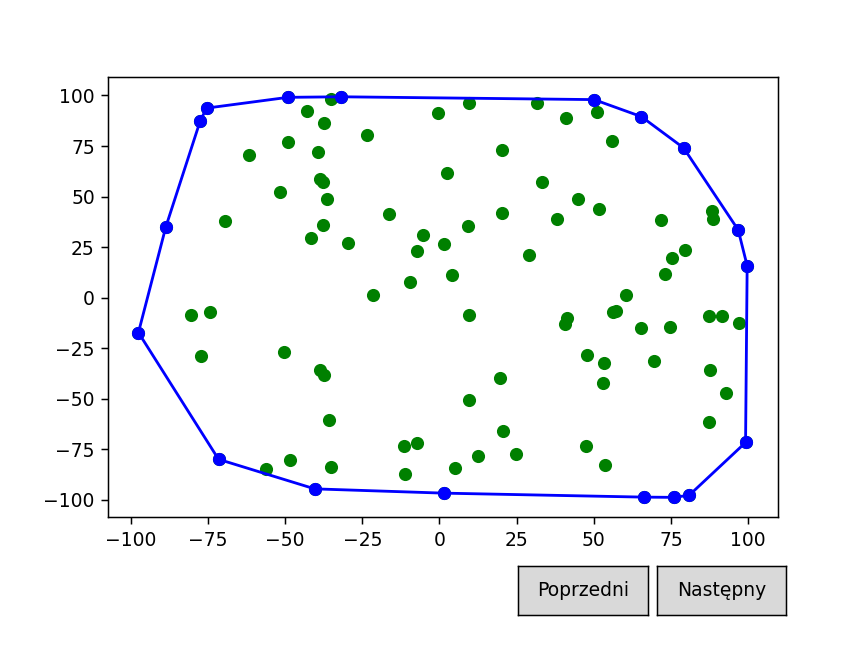

In [20]:
hull,scenes = graham_scan(generate_a())
plot = Plot(scenes)
plot.draw()

## Zbiór B


<IPython.core.display.Javascript object>


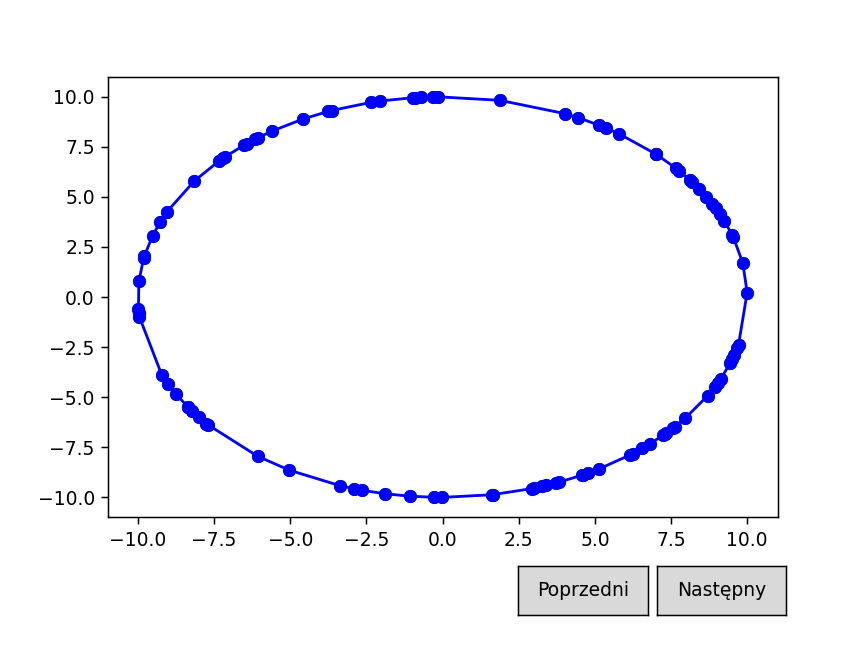

In [21]:
hull,scenes = graham_scan(generate_b())
plot = Plot(scenes)
plot.draw()

### Zbiór C

<IPython.core.display.Javascript object>


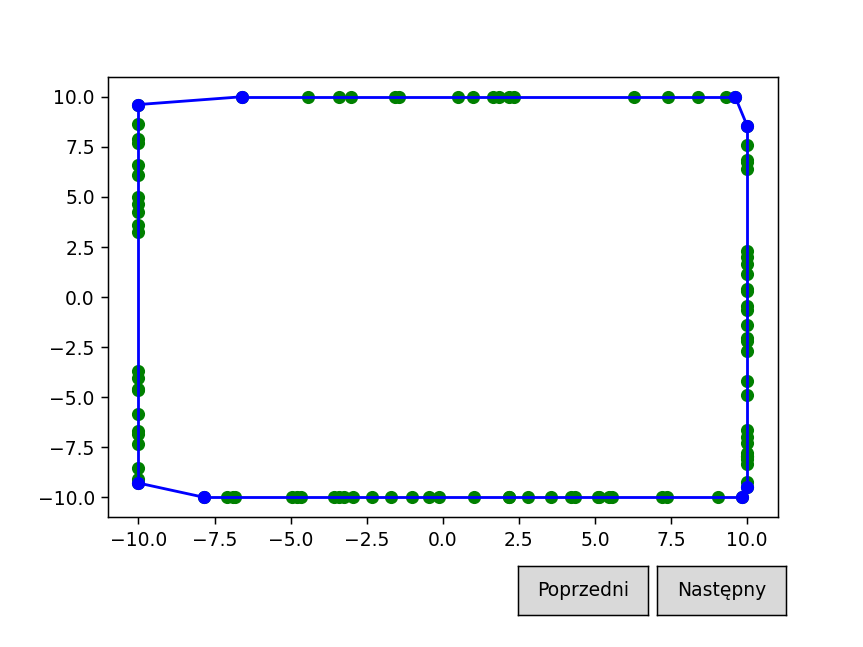

In [22]:
hull,scenes = graham_scan(generate_c())
plot = Plot(scenes)
plot.draw()

### Zbiór D


<IPython.core.display.Javascript object>


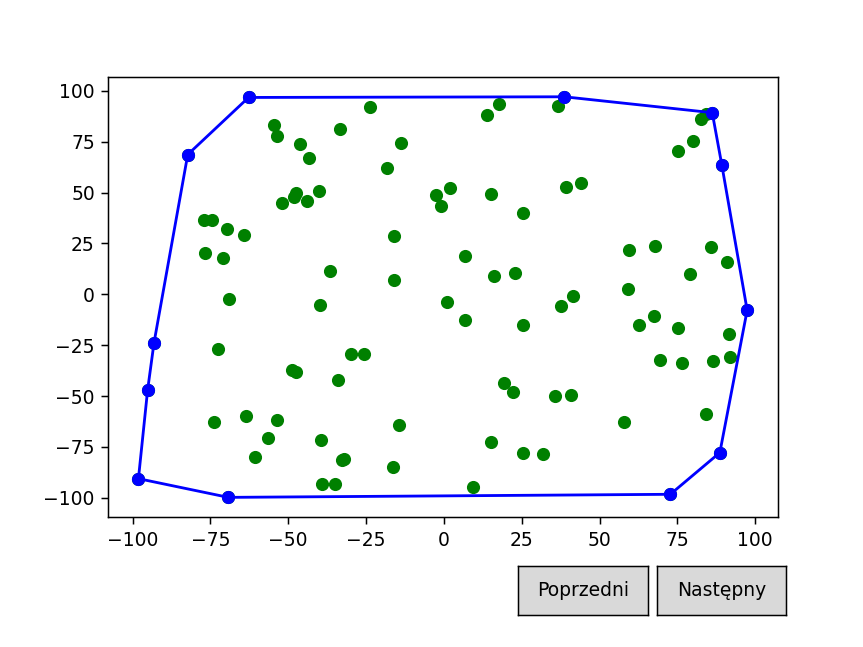

In [23]:
hull,scenes = graham_scan(generate_a())
plot = Plot(scenes)
plot.draw()

## Testy szybkosci


In [24]:
import time
def get_time(data):
    start_time = time.time()
    jarvis_algorithm(data)
    end_time = time.time()
    print("Czas wykonania algorytmu jarvisa na tym zbiorze danych: ", end_time - start_time)
    start_time = time.time()
    graham_scan(data)
    end_time = time.time()
    print("Czas wykonania algorytmu grahama na tym zbiorze danych: ", end_time - start_time)
    

In [27]:
get_time(generate_a(1000))

Czas wykonania algorytmu jarvisa na tym zbiorze danych:  0.03701496124267578
Czas wykonania algorytmu grahama na tym zbiorze danych:  2.008979082107544


In [28]:
get_time(generate_b(1000))

Czas wykonania algorytmu jarvisa na tym zbiorze danych:  3.785038948059082
Czas wykonania algorytmu grahama na tym zbiorze danych:  2.9100027084350586


In [29]:
get_time(generate_c(1000))

Czas wykonania algorytmu jarvisa na tym zbiorze danych:  0.03497719764709473
Czas wykonania algorytmu grahama na tym zbiorze danych:  1.760998249053955


In [30]:
get_time(generate_d(UR = (100,100), side_amount = 100, diag_amount = 200))

Czas wykonania algorytmu jarvisa na tym zbiorze danych:  0.006993532180786133
Czas wykonania algorytmu grahama na tym zbiorze danych:  0.2720019817352295
